# 绘制城市路网图

In [1]:
%matplotlib inline
import typing

import networkx as nx
import osmnx as ox
import geopandas

我们的目标是绘制的是覆盖主城区的某个矩形区域里的路网。根据 `osmnx` 的 API，绘制路网图首先要通过在线或者本地文件来加载城市 graph 和 gdf（GeoDataFrame）。

## 加载路网

用地名在线加载南京政区 GDF 并投影：

In [2]:
# 在线加载 GDF：
# nanjing_gdf = ox.gdf_from_place("南京市, 中国")
# ox.save_gdf_shapefile(nanjing_gdf, "Nanjing-GDF")  # 保存 GDF 至 ./data 目录

# 或者从本地 shapefile 加载 GDF：
nanjing_gdf = geopandas.GeoDataFrame.from_file("./data/Nanjing-GDF")

nanjing_gdf_projected = ox.project_gdf(nanjing_gdf)

加载南京市 graph 并投影：

In [3]:
nanjing_graphml = "Nanjing-highway.graphml"

# 在线加载：
# nanjing_graph: nx.MultiDiGraph = ox.graph_from_place(
#     "南京市, 中国", simplify=True, infrastructure='way["highway"]'
# )
# 并保存为 `.graphml`
# ox.save_graphml(nanjing_graph, filename=nanjing_graphml)
    
# 或者从本地 `.osm` 文件加载：
# nanjing_graph: nx.MultiDiGraph = ox.graph_from_file("./data/Nanjing.osm", simplify=True)

# 或者从本地 `.graphml` 文件加载：
nanjing_graph: nx.MultiDiGraph = ox.load_graphml(nanjing_graphml)

# 投影 graph：
nanjing_graph_projected = ox.project_graph(nanjing_graph)

## Graph 预处理

对于从本地 `.osm` 加载，或者使用 `ox.graph_from_place` 加载时未指定 `infrastructure='way["highway"]'` 的情况，得到的 graph 中含有非道路（highway）的边。

删除 `nanjing_graph` 中非道路（highway）的边。注意 graph 是多重有向图，在删除两点间的一条边或多条边后，两点之间可能不存在 `key == 0` 的边，需要重新设置某一条边的 `key` 为 0。

In [4]:
# 删除非道路的 edge

highway_level_set = set()
nanjing_graph_copy: nx.MultiDiGraph = typing.cast(nx.MultiDiGraph,
                                                  nanjing_graph.copy())

for u, v, key, data in nanjing_graph.edges(data=True, keys=True):
    level = data.get("highway", None)
    if level is None:
        # print(u, v, data)
        nanjing_graph_copy.remove_edge(u, v, key)

    elif isinstance(level, str):
        highway_level_set.add(level)

    elif isinstance(level, typing.Iterable):
        highway_level_set.add(tuple(level))

nanjing_graph_copy2: nx.MultiDiGraph = typing.cast(nx.MultiDiGraph,
                                                   nanjing_graph_copy.copy())
for u, v in nanjing_graph_copy.edges():
    try:
        _0th_edge = nanjing_graph_copy._adj[u][v][0]
    except KeyError:
        _key, _data = nanjing_graph_copy2._adj[u][v].popitem()
        nanjing_graph_copy2.add_edge(u, v, key=0, **_data)

nanjing_graph = nanjing_graph_copy2
del nanjing_graph_copy, nanjing_graph_copy2

因为 `nanjing_graph` 中包含穿越南京边界的道路（边）以及其关联的区域外的节点，需要删除 `nanjing_graph` 中不在南京政区范围（`nanjing_gdf`）内的点，由此删除跨过边界的边：

In [5]:
from geopandas.geoseries import GeoSeries
from geopandas.geodataframe import GeoDataFrame
from shapely.geometry import Point

In [6]:
def graph_in_gdf(graph: nx.MultiDiGraph, gdf: GeoDataFrame):
    graph_copy = graph.copy()
    for node_id, node_data in graph.nodes(data=True):
        point = Point(node_data["x"], node_data["y"])
        for polygon in gdf["geometry"]:
            if not polygon.contains(point):
                graph_copy.remove_node(node_id)
                
    return graph_copy

In [7]:
nanjing_graph = graph_in_gdf(nanjing_graph, nanjing_gdf).copy()

## 绘制 graph

我们可以使用 `ox.plot.plot_figure_ground` 绘制 graph：

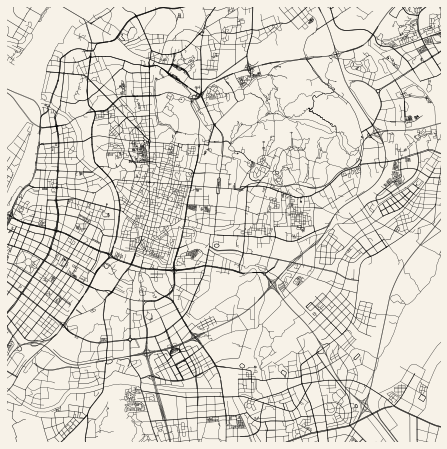

In [8]:
street_widths = {
    "primary": 0.5,
    "secondary": 0.4,
    "tertiary": 0.39
}
default_width=0.3
dist = 10000

fig, axes = ox.plot.plot_figure_ground(
    nanjing_graph, 
    dist=dist,
    street_widths=street_widths, 
    default_width=default_width,
    filename="Nanjing" + f"_{dist / 1000}km", file_format="png",
    edge_color='k', bgcolor="#F7F2E8",
    dpi=900,
    show=True, save=True
)

In [9]:
ox.plot.plot_figure_ground?

但是该函数 API 功能有限，只能绘制正方形区域。为了实现更高程度的自定义，可以使用 `ox.plot_graph` 结合 `bbox` 参数，指定我们所需的绘制范围（矩形区域）。

首先，通过南京市 GDF 的 bbox 数据获取南京行政区划的东南西北范围作为参考：

In [10]:
nanjing_gdf.bbox_west, nanjing_gdf.bbox_east, nanjing_gdf.bbox_north, nanjing_gdf.bbox_south

(0    118.3580264
 Name: bbox_west, dtype: object,
 0    119.2395068
 Name: bbox_east, dtype: object,
 0    32.615778
 Name: bbox_north, dtype: object,
 0    31.2302006
 Name: bbox_south, dtype: object)

据此设定好我们所需的 bbox 范围：

In [11]:
nanjing_bbox = {"west": 118.58, "east": 119, "south": 31.85, "north": 32.18}

调用 `ox.plot_graph` 绘制区域内的 graph 并保存：

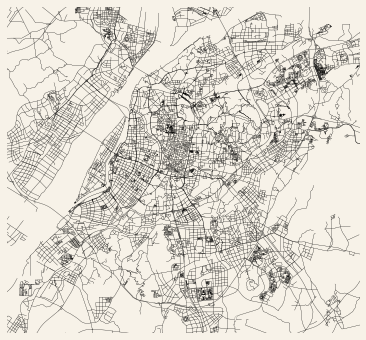

(<Figure size 549.818x432 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1a43bf6650>)

In [12]:
nanjing_plot_filename = (
    f"Nanjing-"
    f"{nanjing_bbox['west']}W-"
    f"{nanjing_bbox['east']}E-"
    f"{nanjing_bbox['south']}S-"
    f"{nanjing_bbox['north']}N"
)

ox.plot_graph(
    nanjing_graph,
    bbox=(
        nanjing_bbox["north"], 
        nanjing_bbox["south"], 
        nanjing_bbox["east"], 
        nanjing_bbox["west"]
    ),
    margin=0,
    node_size=0,
    edge_linewidth=0.15,
    bgcolor="#F7F2E8",
    filename=nanjing_plot_filename, 
    file_format="png",
    edge_color='k',
    dpi=900,
    save=True, show=True
)

## 另一种加载 graph 的方式：从 bbox 获取 graph

In [15]:
nanjing_bbox_filename = (
    f"Nanjing-"
    f"{nanjing_bbox['west']}W-"
    f"{nanjing_bbox['east']}E-"
    f"{nanjing_bbox['south']}S-"
    f"{nanjing_bbox['north']}N"
)

nanjing_bbox_graph = ox.graph_from_bbox(**nanjing_bbox, infrastructure='way["highway"]', truncate_by_edge=True)
ox.save_graphml(
    nanjing_bbox_graph, 
    filename=(
        nanjing_bbox_filename + ".graphml"
    )
)
nanjing_bbox_graph = ox.load_graphml(nanjing_bbox_filename + ".graphml")